In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=5403ba75c56e913f697c9ca6f6fe309de43fa6663230bc4066d3bc5f38185fa6
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


# import


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.neighbors import KNeighborsClassifier
import pickle
# Evaluate performance
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import time

# Methodologys
from sklearn import preprocessing

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

from sklearn.metrics import matthews_corrcoef

from tabulate import tabulate

import random
from itertools import product


##urls

## normalize_with_tanh_estimator

In [3]:
# Define the function for normalization using tanh-estimator method, excluding specified columns
def normalize_with_tanh_estimator(data, mean_std_dict):
    normalized_data = pd.DataFrame()
    for col in data.columns:
          mu, sigma = mean_std_dict[col]
          normalized_col = 0.5 * (np.tanh(0.1 * ((data[col] - mu) / sigma)) + 1)
          normalized_data[col] = normalized_col

    return normalized_data

## Distance calculation


In [4]:
# Function to calculate distance between input sample V and reference point G
def calculate_distance(v, g):
    # return np.linalg.norm(v - g)
    # Ensure v and g are normalized for cosine distance
    v_norm = v / np.linalg.norm(v)
    g_norm = g / np.linalg.norm(g)
    return 1 - np.dot(v_norm, g_norm)

## SOM_Prediction

In [5]:

def som_prediction(sample, d_threshold,sigma, g): #with digma
  y_pred = []
  for sam in sample:
    distance_to_g = calculate_distance(sam, g)
    # print("distance_to_g", distance_to_g)
    # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
    # print("distance to g and d_threshold", distance_to_g, d_threshold)
    is_attack = distance_to_g > d_threshold  # You can adjust the threshold as needed
    # print("is attack value", is_attack)
    y_pred.append(1 if is_attack else 0)

  return y_pred


## Genetic algorithm


In [6]:
def selection(population, fitness_scores):

  tournament_size = 10  # Adjust the tournament size as needed
  selected_parents = []
  population_size = len(population)

  for _ in range(population_size):
        # Randomly select individuals for the tournament
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)

        # Find the individual with the highest fitness in the tournament
        winner = max(tournament, key=lambda x: x[1])[0]

        # Add the winner to the selected parents
        selected_parents.append(winner)

  return selected_parents

def crossover(parents, crossover_rate):
  offspring = []
  for i in range(0, len(parents), 2):
    if random.random() < crossover_rate:
      parent1, parent2 = parents[i], parents[i+1]
      child1 = (parent1 + parent2) / 2
      child2 = (parent1 - parent2) / 2
      offspring.extend([child1, child2])
    else:
      offspring.extend([parents[i], parents[i+1]])
  return offspring

def mutation(offspring, mutation_rate):
  for i in range(len(offspring)):
    if random.random() < mutation_rate:
      offspring[i] += random.uniform(-0.1, 0.1)  # Adjust mutation step
  return offspring

def replace(population, offspring):
  return offspring

def genetic_algorithm(df, num_generations, population_size, crossover_rate, mutation_rate, test_X,test_y,g):
  # Initialization
  # d_threshold_min = 0
  # d_threshold_max = 50
  ## Cosine
  d_threshold_min = 0
  d_threshold_max = 2
  population = [random.uniform(d_threshold_min, d_threshold_max) for _ in range(population_size)]
  fitness_scores = [eval_function(individual, test_X, test_y,g) for individual in population]
  generation_val =[]
  for generation in tqdm(range(num_generations)):
  # for generation in range(num_generations):
    parents = selection(population, fitness_scores)
    offspring = crossover(parents, crossover_rate)
    offspring = mutation(offspring, mutation_rate)
    population = replace(population, offspring)
    fitness_scores = [eval_function(individual, test_X, test_y,g) for individual in population]
    generation_val.append(fitness_scores)

  #plot the fitness score per iteration as graph
  plt.plot(generation_val)
  plt.xlabel('Generation')
  plt.ylabel('Fitness Score')
  plt.title('Fitness Score per Generation')
  plt.show()

  best_index = np.argmax(fitness_scores)
  best_individual = population[best_index]
  return best_individual

def eval_function(individual, test_X, test_y,g):
  # print("Individual", individual)
  sigma = 1
  # Calculate fitness based on individual's d_threshold
  sigma, d_threshold, accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal, rocauc, mcc, eval = get_details_for_som(test_X, test_y, individual, sigma, g)
  return eval

## CF Matrix

In [7]:
def true_vs_predicted(y_true, y_pred):

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Extract counts from confusion matrix
  attack_as_normal = cm[1, 0]
  normal_as_attack = cm[0, 1]
  attack_as_attack = cm[1, 1]
  normal_as_normal = cm[0, 0]

  # Print the results
  print("attack (1) but predicted as normal =", attack_as_normal)
  print("normal (0) but predicted as attack =", normal_as_attack)
  print("attack (1) predicted as attack =", attack_as_attack)
  print("normal (0) predicted as normal =", normal_as_normal)

def true_vs_predicted_with_return(y_true, y_pred):

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Extract counts from confusion matrix
  try:
    attack_as_normal = cm[1, 0]
  except:
    attack_as_normal = None
  try:
    normal_as_attack = cm[0, 1]
  except:
    normal_as_attack = None
  try:
    attack_as_attack = cm[1, 1]
  except:
    attack_as_attack = None
  try:
    normal_as_normal = cm[0, 0]
  except:
    normal_as_normal = None


  return attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal


def evaluate_true_and_predicted_with_return(com,test_y, y_pred):

  attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal = true_vs_predicted_with_return(test_y, y_pred)
  # Generate classification report
  precision_recall = classification_report(test_y, y_pred, output_dict=True, zero_division=1)
  precision_ddos = precision_recall['1']  # Assuming '1' represents DDoS class

  fdr = (1 - precision_ddos['precision'])*100
  # Calculate False Detection Rate (FDR)
  print("\n", classification_report(test_y,y_pred, zero_division=1))
  accuracy = (accuracy_score(test_y, y_pred))*100
  print(f"\nAccuracy : {accuracy} % ")
  print(f"False Detection Rate (FDR): {fdr:.2f}%")
  # result = [com,accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal]
  # Assuming com, accuracy, fdr, etc. are lists or arrays of the same length
  result = [com, accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal]
  columns = ['com', 'accuracy', 'fdr', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']

  # Create a dictionary
  data_dict = {col: [val] for col, val in zip(columns, result)}

  # Create the DataFrame
  # result_df = pd.DataFrame(data_dict)
  print(result)
  print("\n",com)
  # resultant_columns = ['accuracy', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  # result_df = pd.DataFrame(result)
  # result_df.columns = ['comment', 'accuracy', 'FDR', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
  return data_dict


## get_details_for_som

In [8]:
def get_details_for_som(test_X, test_y, d_threshold, sigma, g):

  y_pred_som = som_prediction(test_X, d_threshold, sigma, g)

  accuracy = accuracy_score(test_y, y_pred_som)
  attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal = true_vs_predicted_with_return(test_y, y_pred_som)
  # fdr = (1 - attack_as_attack / (attack_as_attack + normal_as_attack)) * 100
  denominator = attack_as_attack + normal_as_attack
  if denominator == 0:
    fdr = 0  # Setting FDR to zero when denominator is zero
  else:
    fdr = (1 - attack_as_attack / denominator) * 100

  # calculate rocauc
  rocauc = roc_auc_score(test_y, y_pred_som)
  mcc = matthews_corrcoef(test_y, y_pred_som)

  eval = rocauc + mcc

  return sigma, d_threshold, accuracy, fdr, attack_as_normal, normal_as_attack, attack_as_attack, normal_as_normal, rocauc, mcc, eval





In [9]:
def avg_time_per_prediction(dataset_size, total_time):
  return(total_time/dataset_size * 1000)

## Pooling


In [10]:
def max_pool(som_map, pool_size):
  """
  Performs max pooling on a SOM map.

  Args:
    som_map: The SOM map as a NumPy array.
    pool_size: The size of the pooling region.

  Returns:
    The pooled SOM map.
  """

  h, w, c = som_map.shape  # Assuming a 3D SOM map

  out_h = h // pool_size
  out_w = w // pool_size

  pooled_map = np.zeros((out_h, out_w, c))

  for i in range(out_h):
    for j in range(out_w):
      for k in range(c):
        pooled_map[i, j, k] = np.max(som_map[i * pool_size: (i + 1) * pool_size,
                                           j * pool_size: (j + 1) * pool_size, k])

  return pooled_map


## Models prediction


In [11]:
# def som_and_rf_prediction_from_array(test_X, d_threshold, sigma, g, rf_model):
#   y_result = []
#   rf_onlytime = 0
#   for sam in test_X:
#     distance_to_g = calculate_distance(sam, g)
#     # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
#     is_attack = distance_to_g > d_threshold   # You can adjust the threshold as needed
#     som_predicted = [1] if is_attack else [0]
#     if som_predicted == [0]:
#       y_result.append(som_predicted)
#     else:

#       rf_single_pred_start = time.time()
#       rf_pred = rf_model.predict(sam.reshape(1, -1))
#       rf_single_pred_end = time.time()
#       rf_single_pred_time = rf_single_pred_end - rf_single_pred_start
#       rf_onlytime = rf_onlytime + rf_single_pred_time
#       y_result.append(rf_pred)
#   print("rf_total", rf_onlytime)
#   return y_result

import numpy as np
import time

def som_and_rf_prediction_from_array_optimized(test_X, d_threshold, sigma, g, rf_model):
    y_result = []
    rf_onlytime = 0
    distance_to_g_all = np.array([calculate_distance(sam, g) for sam in test_X])
    # p_d_greater_than_x_all = 1 - np.exp(- (distance_to_g_all / sigma)**2)

    for i, sam in enumerate(test_X):
        distance_to_g = distance_to_g_all[i]
        # p_d_greater_than_x = p_d_greater_than_x_all[i]

        is_attack = distance_to_g > d_threshold   # You can adjust the threshold as needed
        som_predicted = [1] if is_attack else [0]

        if som_predicted == [0]:
            y_result.append(som_predicted)
        else:
            rf_single_pred_start = time.time()
            rf_pred = rf_model.predict(sam.reshape(1, -1))
            rf_single_pred_end = time.time()
            rf_single_pred_time = rf_single_pred_end - rf_single_pred_start
            rf_onlytime += rf_single_pred_time
            y_result.append(rf_pred)

    print("rf_total", rf_onlytime)
    return y_result



# def som_and_rf_prediction_for_single(sam, d_threshold, sigma, g, rf_model):
#     # start_time = time.time()
#     # som_predicted = som_prediction([sam], d_threshold, sigma, g)
#     distance_to_g = calculate_distance(sam, g)
#     # p_d_greater_than_x = 1 - np.exp(- (distance_to_g / sigma)**2)  # Cumulative distribution function
#     is_attack = distance_to_g > d_threshold # You can adjust the threshold as needed
#     som_predicted = [1] if is_attack else [0]

#     if som_predicted == [0]:
#       return som_predicted
#     else:
#       rf_single_pred_start = time.time()
#       rf_pred = rf_model.predict(sam.reshape(1, -1))
#       rf_single_pred_end = time.time()
#       rf_single_pred_time = rf_single_pred_end - rf_single_pred_start
#       # print(f"RF single pred time: {rf_single_pred_time} seconds")
#       # rf_pred = [1]
#       return rf_pred

      # end_time = time.time()
      # som_time = end_time - start_time
      # print(f"SOM time: {som_time:.2f} seconds")

def rf_model_prediction_for_single(test_X, rf_model):
  y_result = []
  for sam in test_X:
    rf_pred = rf_model.predict(sam.reshape(1, -1))
    y_result.append(rf_pred)
  return y_result

In [12]:
def get_umatrix_info():
  lists = ['tab10', 'tab20', 'tab20b', 'tab20c', 'Pastel1', 'Pastel2', 'Dark2', 'Set1', 'Set2', 'Set3','coolwarm', 'bwr', 'seismic', 'RdBu', 'PuOr','viridis', 'inferno', 'plasma', 'magma', 'cividis']
  return lists

## umatrix


In [13]:


def plot_u_matrix(u_matrix, title, cmap):
  # u_matrix = som.distance_map()  # Get the U-matrix

  # Plot the U-Matrix before training
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.title(title)
  plt.pcolor(u_matrix, cmap=cmap)
  plt.colorbar()

  plt.show()

## Models Initiation

In [14]:
# def get_model_som(df_normalized):

#   # Filter rows where label equals 0
#   som_filtered_df = df_normalized[df_normalized['label'] == 0]

#   som_train_X = som_filtered_df.iloc[:, :-1].values
#   som_size = 30  # Example size, adjust based on your dataset
#   som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0 )
#   som.random_weights_init(som_train_X)
#   som.train_batch(som_train_X, 1000, verbose = "true")
#   # Calculate the reference point G
#   g = np.median(som.get_weights(), axis=(0, 1))

  # return g

def get_model_rf(X_train, y_train):
  # Initialize Random Forest model
  rf_model = RandomForestClassifier(random_state=42)

  # Fit the model
  rf_model.fit(X_train, y_train)

  return rf_model



# def get_model_som_modified_with_attack(df_normalized):
#     # Split data into normal and attack
#     df_normal = df_normalized[df_normalized['label'] == 0]
#     df_attack = df_normalized[df_normalized['label'] == 1]

#     # Sample a portion of attack data
#     attack_sample_size = int(0.2 * len(df_attack))  # Adjust sample size as needed
#     df_attack_sample = df_attack.sample(n=attack_sample_size)

#     # Combine normal and sampled attack data
#     som_train_X = pd.concat([df_normal, df_attack_sample]).iloc[:, :-1].values

#     som_size = 30  # Example size, adjust based on your dataset
#     som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0)
#     som.random_weights_init(som_train_X)
#     som.train_batch(som_train_X, 1000, verbose="true")

#     # Calculate the reference point G
#     g = np.median(som.get_weights(), axis=(0, 1))

#     return g

# def get_model_som_modified_with_mean(df_normalized):

#   # Filter rows where label equals 0
#   som_filtered_df = df_normalized[df_normalized['label'] == 0]

#   som_train_X = som_filtered_df.iloc[:, :-1].values
#   som_size = 50  # Example size, adjust based on your dataset
#   som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=0.1, random_seed=0 )
#   som.random_weights_init(som_train_X)
#   som.train_batch(som_train_X, 1000, verbose = "true")
#   # Calculate the reference point G
#   # g = np.median(som.get_weights(), axis=(0, 1))
#   g = np.mean(som.get_weights(), axis=(0, 1))

#   return g

import numpy as np
from minisom import MiniSom
from scipy.ndimage import convolve

def get_model_som_modified_with_convo(df_normalized):
  # ... (similar data filtering as before)

  # Filter rows where label equals 0
  som_filtered_df = df_normalized[df_normalized['label'] == 0]

  som_train_X = som_filtered_df.iloc[:, :-1].values

  som_size = 50
  som = MiniSom(som_size, som_size, som_train_X.shape[1], sigma=15, learning_rate=1, random_seed=0)
  # ... (training as before)
  som.random_weights_init(som_train_X)
  u_matrix_before_traning = som.distance_map()
  som.train_batch(som_train_X, 1000, verbose="true")
  u_matrix_After_traning = som.distance_map()
  # Convert weights to a numpy array for convolution
  weights = som.get_weights()
  weights = max_pool(weights, 5)
  # som.weights = weights
  u_matrix_After_pooling = som.distance_map()

  # Define convolution kernel (e.g., Gaussian, Laplacian)
  gaussian_kernel = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]]) / 9  # Example: Gaussian blur kernel

  kernel = gaussian_kernel


    # kernel = laplacian_kernel

    # Apply convolution to each feature map
  convolved_weights = np.zeros_like(weights)
  for i in range(weights.shape[2]):
      convolved_weights[:, :, i] = convolve(weights[:, :, i], kernel, mode='constant', cval=0.0)
  # convolved_weights = weights
  som.weights = convolved_weights
  u_matrix_After_convolution = som.distance_map()

  # Calculate the reference point G
  g = np.mean(convolved_weights, axis=(0, 1))


  # # plotting
  # cmaps = get_umatrix_info()
  # for cmap in cmaps:
  #   plot_u_matrix(u_matrix_before_traning, "U-Matrix before training", cmap)
  #   plot_u_matrix(u_matrix_After_traning, "U-Matrix after training", cmap)


  return g




# Load dataset

In [15]:
### Load the dataset self only

urls = []
comments = []



# #self made data
urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
comments.append("self made data")



In [16]:
# ## Load the dataset all

# urls = []
# comments = []

# ## 1s split
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/combined%20Dataset.csv")
# comments.append("1s split caida2007")

# # # #self made data
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# comments.append("self made data")

urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/1ssplit%20combined%20dataset%20CAIDA%202007.csv")
comments.append("1s split with ")

# # # new 2s splits
# # #filled
urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20filled.csv")
comments.append("filled 2s split with bandwidth caida 2007")

# ## unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20unfilled.csv")
# comments.append("unfilled 2s split with bandwidth")

# ## filled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20filled.csv")
# comments.append("filled 2s split without bandwidth")

# ## unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/caida2007/csv/2ssplit%20combined%20dataset%20CAIDA%202007%20unfilled.csv")
# comments.append("unfilled 2s split without bandwidth")

# ## ids 2017 benign only
# ## filled
urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_filled_entropy.csv")
comments.append("ids 2017 benign only filled")

# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_filled_entropy.csv")
# comments.append("ids 2017 benign only filled without bandwidth")

# ## unfilled
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_unfilled_entropy.csv")
# comments.append("ids 2017 benign only unfilled")

# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/DATASET/isd%202017/ids-2017-benign-Monday-WorkingHours2s%20unlabeled_unfilled_entropy.csv")
# comments.append("ids 2017 benign only unfilled without bandwidth")


## normalize_df


In [17]:
def normalize_df(df, mean_std_dict):
    # taking x values only
    x_values = df.iloc[:, :-1].values
    # taking labels only
    labels = df.iloc[:, -1].values

    # ## Normalizng with tanh optimization
    x_values_df = pd.DataFrame(x_values, columns=df.columns[:-1])
    normalized_xvalues = normalize_with_tanh_estimator(x_values_df, mean_std_dict)



    normalized_df = pd.DataFrame(normalized_xvalues, columns=df.columns[:-1])



    # Adding labels back to the normalized dataframe
    normalized_df['label'] = labels

    return normalized_df

## show as table

In [18]:


def show_as_table(data, value):
  # Extracting relevant data for tabulate
  # print(data)
  table_data = []
  for item in data:
      som_row = item['som_values'][0]['evaluation1']
      rf_row = item['rf_values'][0]['evaluation1']
      combined_row = item['combined_values'][0]['evaluation1']
      comment = item['som_values'][0]['evaluation1']['com']
      d_threshold = item['som_d_threshold']


      table_data.append([
          'SOM',
          som_row['accuracy'][0],
          som_row['fdr'][0],
          som_row['attack_as_normal'][0],
          som_row['normal_as_attack'][0],
          som_row['attack_as_attack'][0],
          som_row['normal_as_normal'][0],
          item['som_values'][0]['som_time'],
          item['som_values'][0]['avg_time']
      ])

      table_data.append([
          'RF',
          rf_row['accuracy'][0],
          rf_row['fdr'][0],
          rf_row['attack_as_normal'][0],
          rf_row['normal_as_attack'][0],
          rf_row['attack_as_attack'][0],
          rf_row['normal_as_normal'][0],
          item['rf_values'][0]['rf_time'],
          item['rf_values'][0]['avg_time']
      ])

      table_data.append([
          'Combined',
          combined_row['accuracy'][0],
          combined_row['fdr'][0],
          combined_row['attack_as_normal'][0],
          combined_row['normal_as_attack'][0],
          combined_row['attack_as_attack'][0],
          combined_row['normal_as_normal'][0],
          item['combined_values'][0]['combined_time'],
          item['combined_values'][0]['avg_time']
      ])

  # Headers for the table
  headers = ['Method', 'Accuracy (%)', 'FDR (%)', 'Attack as Normal', 'Normal as Attack',
            'Attack as Attack', 'Normal as Normal', 'Execution Time (s)', 'Average Time (ms)']

  # Generate the table using tabulate
  table = tabulate(table_data, headers=headers, tablefmt='grid')

  ## if combined row accuracy > 90 print hi
  if combined_row['accuracy'][0] > 95:
    ## if som accuracy > 90 print hi
    if som_row['accuracy'][0] > 95:
      ## print comment


      # print("hi")
    # print("hi")
  # Print the table
      print(value)
      print(f"{comment} with {d_threshold}")
      # print(table)




## som_with_varying_sigma_and_d_threshold_ testing2


In [19]:
def som_with_varying_sigma_and_d_threshold_for_method_testing_combined(df, visual =1):

  df = df
  sigma_min = 0.001
  sigma_max = 1
  sigma_step = 0.0001

  ## d_threshold
  d_threshold_min = 0
  d_threshold_max =0.12
  d_threshold_step = 0.00001


  # Generate arrays of varying values for sigma and d_threshold
  sigma_values = np.arange(sigma_min, sigma_max + sigma_step, sigma_step)
  d_threshold_values = np.arange(d_threshold_min, d_threshold_max + d_threshold_step, d_threshold_step)
  max = len(d_threshold_values)
  i = 1
  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  df_normalized = normalize_df(df, mean_std_dict)
  # df_normalized = df


  # Get trained som model
  g = get_model_som_modified_with_convo(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  result = []
  sigma = 1

  for d_threshold in tqdm(d_threshold_values, desc="Processing d_threshold_values"):
    result.append(get_details_for_som(test_X, test_y, d_threshold, sigma, g))




  resultant_columns = ['sigma', 'd_threshold', 'accuracy', 'FDR', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal','rocauc', 'mcc', 'eval']
  resultant_df = pd.DataFrame(result,columns=resultant_columns)
  if visual == 1:
    vision_of_varying(resultant_df)

  d_threshold_value = get_d_threshold_value_for_max_eval(resultant_df)
  print(f"d_threshold_value from function : {d_threshold_value}")

  return d_threshold_value



## som_with_som_and_rf_actual_modified_som testing2


In [20]:

def som_with_som_and_rf_actual_modified_som_combined(df, com, bandflag):
  #for  evaluating time of single evaluation

  if bandflag == 1:
    # Check if the column exists
    column_to_drop = 'bandwidth'
    if column_to_drop in df.columns:
        # Drop the column
        df.drop(columns=[column_to_drop], inplace=True)
        print(f"\n'{column_to_drop}' column dropped.")
    else:
        print(f"\nColumn '{column_to_drop}' not found in the DataFrame.")

  # ## for tanh estimation
  # som_d_threshold = 0.13309999999999966  # Predefined distance threshold
  som_sigma =  0.139099999999999  # Probability threshold

  ### for normalizing
  # som_d_threshold = 0.020999999999999998  # Predefined distance threshold
  # som_sigma =  0.020999999999999998  # Probability threshold

  ### for convolution
  # som_d_threshold = 1.081 # predefined
  # som_d_threshold = som_with_varying_sigma_and_d_threshold_for_method_testing_combined(df)




  # Define the columns to exclude from normalization
  exclude_cols = ['label']  # Add more columns here if needed
  # Calculate and store the mean and standard deviation for each dimension, excluding specified columns
  mean_std_dict = {}
  for col in df.columns:
      if col not in exclude_cols:
          mean_std_dict[col] = (df[col].mean(), df[col].std())

  # Normalize the dataset using tanh-estimator method, excluding specified columns
  # df_normalized = normalize_with_tanh_estimator(df, mean_std_dict)
  # df_normalized = df
  # using normalization of scikit learn except label column
  df_normalized = normalize_df(df, mean_std_dict)


  # Get trained som model
  g = get_model_som_modified_with_convo(df_normalized)

  #for test
  test_X = df_normalized.iloc[:, :-1].values
  test_y = df_normalized.iloc[:, -1].values

  # d_threshold_min = 0.001
  # d_threshold_max = 20
  # som_d_threshold = genetic_algorithm(df, num_generations=100, population_size=50, crossover_rate=0.8, mutation_rate=0.2, test_X,test_y)
  som_d_threshold = genetic_algorithm(df, 50, 50, 0.8, 0.2, test_X,test_y, g)

  print(f"som_d_threshold : {som_d_threshold}")

  X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, test_size=0.3, random_state=42)

  rf_model = get_model_rf(X_train, y_train)

  test_X = X_train
  test_y = y_train


  # data_size = len(test_X)
  # som_start_time = time.time()
  # y_pred_som = som_prediction(test_X, som_d_threshold, som_sigma, g)
  # som_end_time = time.time()
  # som_time = som_end_time - som_start_time
  # print(f"\nSOM Avg per sample : {avg_time_per_prediction(data_size, som_time)} ms")
  # print(f"SOM time: {som_time} seconds\n")

  # rf_start_time = time.time()
  # # y_pred_rf = rf_model.predict(test_X)
  # y_pred_rf = rf_model_prediction_for_single(test_X, rf_model)
  # rf_end_time = time.time()
  # rf_time = rf_end_time - rf_start_time
  # print(f"RF Avg per sample : {avg_time_per_prediction(data_size, rf_time)} ms")
  # print(f"RF time: {rf_time} seconds\n")


  # combined_start_time = time.time()
  # y_pred_som_and_rf = som_and_rf_prediction_from_array_optimized(test_X, som_d_threshold, som_sigma, g, rf_model)
  # combined_end_time = time.time()
  # combined_time = combined_end_time - combined_start_time
  # print(f"Combined Avg per sample : {avg_time_per_prediction(data_size, combined_time)} ms")
  # print(f"Combined time: {combined_time} seconds\n")


  data_size = len(test_X)
  som_start_time = time.time()
  y_pred_som = som_prediction(test_X, som_d_threshold, som_sigma, g)
  som_end_time = time.time()
  som_time = som_end_time - som_start_time
  print(f"\nSOM Avg per sample : {avg_time_per_prediction(data_size, som_time)} ms")
  print(f"SOM time: {som_time} seconds\n")

  rf_start_time = time.time()
  # y_pred_rf = rf_model.predict(test_X)
  y_pred_rf = rf_model_prediction_for_single(test_X, rf_model)
  rf_end_time = time.time()
  rf_time = rf_end_time - rf_start_time
  print(f"RF Avg per sample : {avg_time_per_prediction(data_size, rf_time)} ms")
  print(f"RF time: {rf_time} seconds\n")


  combined_start_time = time.time()
  y_pred_som_and_rf = som_and_rf_prediction_from_array_optimized(test_X, som_d_threshold, som_sigma, g, rf_model)
  combined_end_time = time.time()
  combined_time = combined_end_time - combined_start_time
  print(f"Combined Avg per sample : {avg_time_per_prediction(data_size, combined_time)} ms")
  print(f"Combined time: {combined_time} seconds\n")





  #### evaluation
  print("____"*80)
  print("\n For SOM Model")
  print("--"*40)
  som_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som), som_time, avg_time_per_prediction(data_size, som_time)]
  som_values_dict = {'evaluation1': som_values[0], 'som_time': som_time, 'avg_time' : som_values[2] }

  print("\n For RF Model")
  print("--"*40)
  rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_rf), rf_time, avg_time_per_prediction(data_size, rf_time)]
  rf_values_dict = {'evaluation1': rf_values[0], 'rf_time': rf_time, 'avg_time' : rf_values[2] }
  print("\n For SOM and RF Model")
  print("--"*40)
  y_pred_som_and_rf_values = [evaluate_true_and_predicted_with_return(com,test_y, y_pred_som_and_rf), combined_time, avg_time_per_prediction(data_size, combined_time)]
  combined_values_dict = {'evaluation1': y_pred_som_and_rf_values[0], 'combined_time': combined_time, 'avg_time' : y_pred_som_and_rf_values[2] }
  result = [som_values_dict, rf_values_dict, combined_values_dict, som_d_threshold]
  columns = ["som_values","rf_values", "combined_values", "som_d_threshold"]
  data_dict = {col: [val] for col, val in zip(columns, result)}
  print("____"*80)
  # print(result)
  # resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
  # resultant_df = pd.DataFrame(result,columns=resultant_columns)
  return data_dict








## max eval d_threshold

In [21]:
def get_d_threshold_value_for_max_eval(value_pd):
    # printing all the max eval rows
    max_eval_rows = value_pd[value_pd['eval'] == value_pd['eval'].max()]

    # Check if there's more than one row with maximum 'eval'
    if len(max_eval_rows) > 1:
        # Find the row with the lowest 'attack_as_normal' value
        min_attack_row = max_eval_rows.loc[max_eval_rows['attack_as_normal'].idxmin()]
        print(min_attack_row['d_threshold'])
        return min_attack_row['d_threshold']
    else:
        # If only one row has maximum 'eval', print that d_threshold of that row
        print(max_eval_rows['d_threshold'].iloc[0])
        return max_eval_rows['d_threshold'].iloc[0]

## vision


In [22]:
def vision_of_varying(df_results):
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  import matplotlib.pyplot as plt
  import seaborn as sns

  if not True:
    # Assuming df_results contains the data from the previous code snippet

    # Convert dataframe columns to numpy arrays for plotting
    sigma_values = df_results['sigma'].values
    d_threshold_values = df_results['d_threshold'].values
    accuracy_values = df_results['accuracy'].values

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_trisurf(sigma_values, d_threshold_values, accuracy_values, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('Sigma')
    ax.set_ylabel('d_threshold')
    ax.set_zlabel('Accuracy')
    ax.set_title('Accuracy vs. Sigma and d_threshold')

    # Show the plot
    plt.show()

  else:
      # Convert dataframe columns to numpy arrays for plotting
      d_threshold_values = df_results['d_threshold'].values
      accuracy_values = df_results['accuracy'].values
      fdr = df_results['FDR'].values

      # # Create a 2D plot (For showing only)
      # plt.figure()

      # # Plot the data
      # plt.plot(d_threshold_values, accuracy_values, marker='o', linestyle='-')

      # # Set labels and title
      # plt.xlabel('d_threshold')
      # plt.ylabel('Accuracy')
      # plt.title('Accuracy vs. d_threshold')

      # # Show the plot
      # plt.show()



  # Plotting changes in accuracy with respect to d_threshold
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='accuracy', hue='sigma', marker='o')
  plt.title('Accuracy vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('Accuracy')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in fdr with respect to d_threshold
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='FDR', hue='sigma', marker='o')
  plt.title('FDR vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('FDR')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in rocauc with respect to d_threshold

  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='rocauc', hue='sigma', marker='o')
  plt.title('rocauc vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('rocauc')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in mcc with respect to d_threshold color green
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='mcc', hue='sigma', marker='o')
  plt.title('mcc vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('mcc')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()

  # Plotting changes in eval with respect to d_threshold graph color green
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_results, x='d_threshold', y='eval', hue='sigma', marker='o')
  plt.title('eval vs d_threshold')
  plt.xlabel('d_threshold')
  plt.ylabel('eval')
  plt.legend(title='sigma')
  plt.grid(True)
  plt.show()


## config

## main

Iteration : 0
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.005705595457220662


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


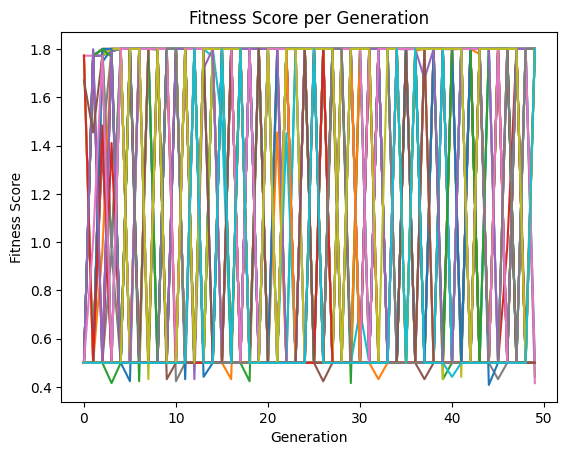

som_d_threshold : 0.007470096982841651

SOM Avg per sample : 0.01045827115519663 ms
SOM time: 0.0065155029296875 seconds

RF Avg per sample : 8.064689069842833 ms
RF time: 5.024301290512085 seconds

rf_total 1.7381093502044678
Combined Avg per sample : 2.8072241604041133 ms
Combined time: 1.7489006519317627 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.95      0.94      0.95       340
           1       0.93      0.94      0.94       283

    accuracy                           0.94       623
   macro avg       0.94      0.94      0.94 

100%|██████████| 50/50 [02:27<00:00,  2.95s/it]


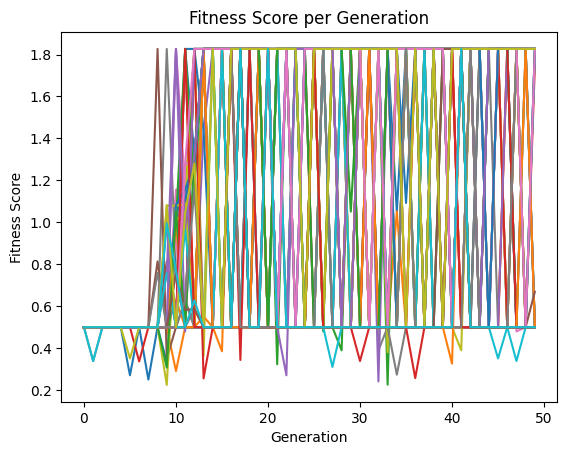

som_d_threshold : 0.0024454875252985786

SOM Avg per sample : 0.01015509750946871 ms
SOM time: 0.025885343551635742 seconds

RF Avg per sample : 6.792244045067507 ms
RF time: 17.313430070877075 seconds

rf_total 10.038248777389526
Combined Avg per sample : 3.96377519328438 ms
Combined time: 10.103662967681885 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1023
           1       0.92      1.00      0.96      1526

    accuracy                           0.95      2549
   macro avg       0.96      0.94      0.9

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


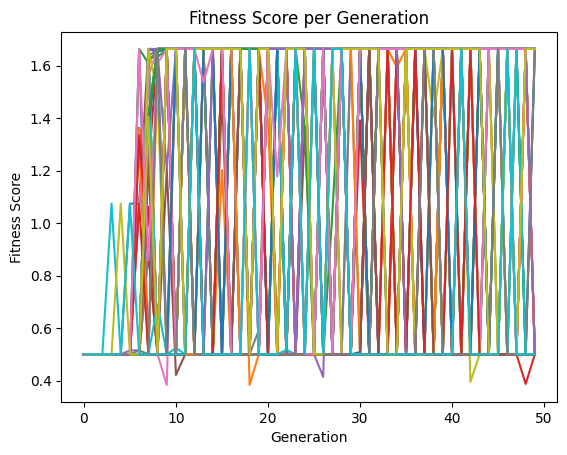

som_d_threshold : 0.003959928169706334

SOM Avg per sample : 0.009962131121458719 ms
SOM time: 0.012741565704345703 seconds

RF Avg per sample : 6.618407855656485 ms
RF time: 8.464943647384644 seconds

rf_total 5.0379650592803955
Combined Avg per sample : 3.958911985228824 ms
Combined time: 5.063448429107666 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.81      0.89      0.85       418
           1       0.94      0.90      0.92       861

    accuracy                           0.89      1279
   macro avg       0.87      0.89      0.88

100%|██████████| 50/50 [09:08<00:00, 10.96s/it]


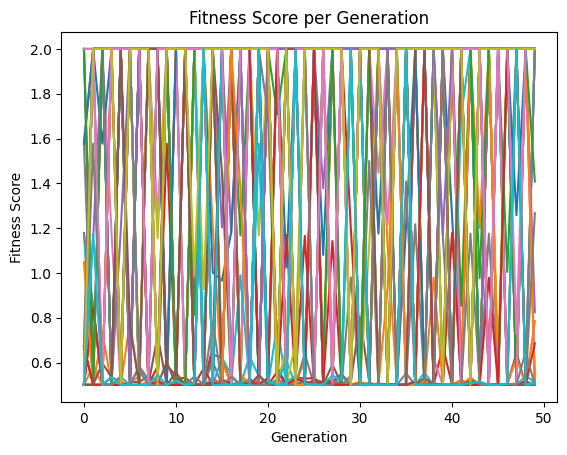

som_d_threshold : 0.038898497171080286

SOM Avg per sample : 0.010343013171659636 ms
SOM time: 0.10547804832458496 seconds

RF Avg per sample : 7.24823768523703 ms
RF time: 73.91752791404724 seconds

rf_total 0
Combined Avg per sample : 0.020990420332327148 ms
Combined time: 0.21406030654907227 seconds

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

 For SOM Model
--------------------------------------------------------------------------------


KeyError: '1'

In [23]:


# #self made data
# urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# comments.append("self made data")





results = []
iteration = 0
for url in urls:
  comment = comments[iteration]
  if 'without bandwidth' in comment:
    bandflag = 1
  else:
    bandflag = 0
  print(f"Iteration : {iteration}")

  df = pd.read_csv(url)
  if iteration >= len(results):
        results.append([])

  value = som_with_som_and_rf_actual_modified_som_combined(df,comment, bandflag) # testing for all datasets with modified som and rf

  results[iteration].append(value)
  iteration = iteration + 1


In [ ]:
 0.006130000000000001
results

In [ ]:
# #save results to self_data_only.pkl
# with open('all_data_trial.pkl', 'wb') as f:
#     pickle.dump(results, f)


In [39]:
value1 = results
for value in value1:
  print(value[0])
  comment = value[0]['som_values'][0]['evaluation1']['com']
  print("com",comment)
  show_as_table(value, comment)

{'som_values': [{'evaluation1': {'com': ['self made data'], 'accuracy': [94.22150882825039], 'fdr': [6.968641114982576], 'attack_as_normal': [16], 'normal_as_attack': [20], 'attack_as_attack': [267], 'normal_as_normal': [320]}, 'som_time': 0.0065155029296875, 'avg_time': 0.01045827115519663}], 'rf_values': [{'evaluation1': {'com': ['self made data'], 'accuracy': [100.0], 'fdr': [0.0], 'attack_as_normal': [0], 'normal_as_attack': [0], 'attack_as_attack': [283], 'normal_as_normal': [340]}, 'rf_time': 5.024301290512085, 'avg_time': 8.064689069842833}], 'combined_values': [{'evaluation1': {'com': ['self made data'], 'accuracy': [97.43178170144462], 'fdr': [0.0], 'attack_as_normal': [16], 'normal_as_attack': [0], 'attack_as_attack': [267], 'normal_as_normal': [340]}, 'combined_time': 1.7489006519317627, 'avg_time': 2.8072241604041133}], 'som_d_threshold': [0.007470096982841651]}
com ['self made data']
{'som_values': [{'evaluation1': {'com': ['1s split with '], 'accuracy': [94.86072969792076

IndexError: list index out of range

In [ ]:
#100 gen 10 tournamnet all dataset
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#100 gen 10 tournamnet multi dataset
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#100 gen 10 tournamnet multi dataset
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#100 gen 10 tournamnet
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#100 gen 10 tournamnet
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#100 max
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#100 max
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#50 max
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#50 max
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#50 max
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#50
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#50
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#10
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
#1000
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

## euclidian normal

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

## cosine normal

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

## cosine

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

## Euclidian

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
value1 = results
for value in value1:
  show_as_table(value)

In [ ]:
show_as_table([value1])

In [ ]:
# #save results to self_data_only.pkl
# with open('self_data_only.pkl', 'wb') as f:
#     pickle.dump(results, f)


In [ ]:
## read from self.pkl as results
with open('self_data_only.pkl', 'rb') as f:
    results = pickle.load(f)

In [ ]:
print(results)

In [ ]:
value1 = results[0][0]
for value in value1:
  # print(f"variation : [[{value}]]")
  show_as_table([results[0][0][value]],value)
value1 = results[0][0]
for value in value1:
  # print(f"variation : [[{value}]]")
  show_as_table([results[1][0][value]],value)
  value1 = results[0][0]
for value in value1:
  # print(f"variation : [[{value}]]")
  show_as_table([results[2][0][value]],value)
  value1 = results[0][0]


## tables


In [ ]:
# final_result = {}

In [ ]:
final_result

In [ ]:
for data in results: # with median 50X50 50 gen tanh normalize convolution laplacian
  show_as_table(data)
final_result['with median 50X50 50 gen tanh normalize convolution laplacian'] = data

In [ ]:
# for data in results: # with median 50X50 50 gen tanh normalize
#   show_as_table(data)
# final_result['with median 50X50 50 gen tanh normalize'] = data

In [ ]:
for data in results: # with mean 50X50 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 30X30 10 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 30X30 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 10X10 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 100X100 50 gen tanh normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 100X100 500 gen custom normalize
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100 500 gen customdef normalize convo laplacian
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100 50 gen
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100 500 gen
  show_as_table(data)

In [ ]:
for data in results: # with mean 100 X 100
  show_as_table(data)

In [ ]:
for data in results: # with mean 50 X 50
  show_as_table(data)

In [ ]:
for data in results: # with mean convo laplacian avgpooled
  show_as_table(data)

In [ ]:
for data in results: # with mean convo laplacian maxpooled
  show_as_table(data)

In [ ]:
for data in results: # with mean convo laplacian
  show_as_table(data)

In [ ]:
for data in results: # with median convo laplacian
  show_as_table(data)

In [ ]:
for data in results: # with median convo gaussian
  show_as_table(data)

In [ ]:
for data in results: # with mean convo gaussian
  show_as_table(data)

In [ ]:
result_df = pd.DataFrame(results[0][0]["som_values"][0])
result_df

In [ ]:
df_test = pd.DataFrame(results[0]['som_values'][0][0])
df_test

In [ ]:
# var_1_with_mean_convolution_and_gaussian = results

In [ ]:
results_df = pd.DataFrame(results)
results_df

## other


In [ ]:
# make each row of result_df into separate dfs
for i in range(len(results)):
    results[i] = pd.DataFrame(results[i])
    results[i].columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
    # results[i] = results[i].astype(float)
    # print(results[i])
results[0]

In [ ]:
# each column of results[0] into a dataframe
df1 = results[0]['som_values']
df2 = results[0]['rf_values']
df3 = results[0]['y_pred_som_and_rf_values']

In [ ]:
df1[0][0]

In [ ]:
value_pd1 = (df1[0][0])
data_dicts = value_pd1
rows = []

# Iterate over each dictionary and convert to DataFrame row
for data_dict in data_dicts:
    rows.append(pd.DataFrame(data_dict, index=[0]))

# Concatenate all rows into a single DataFrame
df = pd.concat(rows, ignore_index=True)

df

In [ ]:
df

In [ ]:
## printing all the max accuracy rows
value_pd[value_pd['accuracy'] == value_pd['accuracy'].max()]

In [ ]:
get_d_threshold_value_for_max_eval(value_pd)

In [ ]:
## printing all the max accuracy rows
value_pd[value_pd['accuracy'] == value_pd['accuracy'].max()]

In [ ]:


# # #self made data
# # urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# # comments.append("self made data")





# results = []
# iteration = 0
# for url in urls:
#   comment = comments[iteration]
#   if 'without bandwidth' in comment:
#     bandflag = 1
#   else:
#     bandflag = 0
#   print(f"Iteration : {iteration}")

#   df = pd.read_csv(url)

#   # y_pred_som_and_rf = with_som_and_rf(df,comment, bandflag) # without rf modify
#   value = som_with_som_and_rf_actual(df,comment, bandflag) # with rfmodify and working
#   # value = som_with_varying_sigma_and_d_threshold(df)

#   results.append(value)
#   iteration = iteration + 1


In [ ]:
# y_pred_som_and_rf
value_1 = pd.DataFrame(value_pd[0])
value_1

In [ ]:
# results

In [ ]:
# resultant_columns = ['som_values', 'rf_values', 'y_pred_som_and_rf_values']
# resultant_df = pd.DataFrame(results,columns=resultant_columns)

In [ ]:
# resultant_df_som = resultant_df['som_values']
# resultant_df_rf = resultant_df['rf_values']
# resultant_df_som_and_rf = resultant_df['y_pred_som_and_rf_values']

In [ ]:
# resultant_df_som

In [ ]:
# resultant_df_rf

In [ ]:
# resultant_columns = ['com','accuracy', 'attack_as_normal', 'normal_as_attack', 'attack_as_attack', 'normal_as_normal']
# resultant_df_som = pd.DataFrame(resultant_df_som,columns=resultant_columns)

In [ ]:


# # #self made data
# # urls.append("https://raw.githubusercontent.com/sudomaster00081/MscProj/main/Implimentation/som_data.csv")
# # comments.append("self made data")





# results = []
# iteration = 0
# for url in urls:
#   comment = comments[iteration]
#   if 'without bandwidth' in comment:
#     bandflag = 1
#   else:
#     bandflag = 0
#   print(f"Iteration : {iteration}")

#   df = pd.read_csv(url)

#   # y_pred_som_and_rf = with_som_and_rf(df,comment, bandflag) # without rf modify
#   value = som_with_som_and_rf_actual(df,comment, bandflag) # with rfmodify and working
#   # value = som_with_varying_sigma_and_d_threshold(df)

#   results.append(value)
#   iteration = iteration + 1


In [ ]:
# resultant_df_som

In [ ]:
# y_pred_som_and_rf

In [ ]:
# result